In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import Ipynb_importer
from utils_x import *
from parameters_x import *




importing Jupyter notebook from utils_x.ipynb
importing Jupyter notebook from parameters_x.ipynb


In [33]:
print("------------------- load data--------------------")
data = pd.read_csv('index500_v3.csv')


# print("---------------- factor adjustment ------------------")
# gb = data.groupby(['unique_symbol'])['adjustment']
# data['rolling_adjustment'] = gb.transform(lambda x: x.rolling(31).sum())



print("--------------- -- stationary pre--------------------")
data["r"] = data["close"]/ data["open"] - 1
data["amplitude"] = (data["high"] - data["low"]) / data["close"]
# data["amplitude_ratio"] = (data["high"] - data["low"]) / (data["close"] - data["open"])
# gb = data.groupby(['date_time'])['open']
# data['open_stationary'] = gb.transform(lambda x: (x-x.mean())/x.std())
# gb = data.groupby(['date_time'])['close']
# data['close_stationary'] = gb.transform(lambda x: (x-x.mean())/x.std())
# gb = data.groupby(['date_time'])['turnover']
# data['turnover_stationary'] = gb.transform(lambda x: (x-x.mean())/x.std())
# gb = data.groupby(['date_time'])['volume']
# data['volume_stationary'] = gb.transform(lambda x: (x-x.mean())/x.std())


gb = data.groupby(['date_time'])['open']
data['open'] = gb.transform(lambda x: (x-x.mean())/x.std())
gb = data.groupby(['date_time'])['close']
data['close'] = gb.transform(lambda x: (x-x.mean())/x.std())
gb = data.groupby(['date_time'])['turnover']
data['turnover'] = gb.transform(lambda x: (x-x.mean())/x.std())
gb = data.groupby(['date_time'])['volume']
data['volume'] = gb.transform(lambda x: (x-x.mean())/x.std())

print(data)
del data["Unnamed: 0"]
time_series = list(sorted(set(list(data.date_time))))    
n_use_f = set(np.array(['unique_symbol', 'date_time', 't+1_open','t+2_open', 'return', 'label', 'rank_label', "use_tag", "adjustment"
                        ,'t+2_adjustment', "y_open", "rolling_adjustment"]))
use_f = list(set(np.array(data.columns)) - n_use_f)
print(sorted(use_f))
print(len(use_f))

------------------- load data--------------------
---------------- factor adjustment ------------------
--------------- -- stationary pre--------------------
        Unnamed: 0  unique_symbol   date_time     close  turnover      open  \
0                3            786  2010-01-29  0.258448  5.079438  0.122323   
1               10            777  2010-01-29  0.557687 -0.355361  0.574471   
2               14            762  2010-01-29  0.904906 -0.257995  0.948040   
3               19            755  2010-01-29 -0.668311 -0.374843 -0.657020   
4               24            748  2010-01-29 -0.507959 -0.010482 -0.533355   
...            ...            ...         ...       ...       ...       ...   
903735     4565336            960  2017-12-27 -0.201918  0.368563 -0.211886   
903736     4565344            969  2017-12-27 -0.445171 -0.310498 -0.448902   
903737     4565362            897  2017-12-27 -0.777103 -0.474829 -0.775863   
903738     4565363            970  2017-12-27 -0.129

In [42]:
qq = data[data["unique_symbol"] == 786].copy()
qq = qq.reset_index()

In [43]:
qq[qq["adjustment"] != 0]

,index,unique_symbol,date_time,close,turnover,open,high,low,volume,use_tag,...,wap23,wap24,wap25,wap26,wap27,wap28,wap29,rolling_adjustment,r,amplitude
89,43517,786,2010-06-18,-0.018938,-0.141073,-0.043736,12.54,12.11,-0.231505,1,...,1.018233,0.987507,1.017425,1.004052,0.979553,1.001254,1.007859,-0.1200,-0.027113,0.035246
331,161259,786,2011-06-22,0.199581,0.005961,0.181218,14.99,14.70,-0.166637,1,...,0.950984,0.966552,0.959412,0.968827,0.968690,0.995718,0.999962,-0.1650,0.006757,0.019463
565,274297,786,2012-06-12,0.415174,-0.194902,0.404556,14.03,13.73,-0.391169,1,...,1.016254,1.025322,1.038572,1.033214,1.022499,1.018808,1.019231,-0.2900,0.008708,0.021583
806,392332,786,2013-06-14,0.992522,0.168649,1.012304,18.97,18.32,-0.256948,1,...,0.970796,0.985360,0.979515,0.979268,0.958796,0.918676,0.938651,-0.3177,0.016667,0.034373
1042,508810,786,2014-06-12,0.297365,-0.281793,0.326215,14.10,13.86,-0.415797,1,...,1.061576,1.056844,1.049721,1.081443,1.073086,1.076908,1.068255,-0.4300,-0.014894,0.017279
1242,654622,786,2015-10-26,-0.083612,-0.807389,-0.091181,16.72,16.72,-0.848172,1,...,1.469903,1.487771,1.515061,1.484091,1.441996,1.438807,1.434546,-19.0075,0.000000,0.000000
1376,716045,786,2016-05-13,-0.467745,-0.183679,-0.457606,8.98,8.65,0.016746,1,...,1.115890,1.081893,1.093758,1.112250,1.120797,1.086621,1.086594,-0.1750,-0.022472,0.037931
1614,830730,786,2017-05-16,-0.009907,2.894797,-0.069123,14.90,13.77,2.575260,1,...,1.134830,1.224038,1.142507,1.032558,1.029220,0.938352,0.836496,-0.1800,0.075036,0.075839


In [49]:
qq.iloc[79:99][["adjustment","rolling_adjustment","date_time"]]

,adjustment,rolling_adjustment,date_time
79,0.00,0.00,2010-06-01
80,0.00,0.00,2010-06-02
81,0.00,0.00,2010-06-03
82,0.00,0.00,2010-06-04
83,0.00,0.00,2010-06-07
84,0.00,0.00,2010-06-08
85,0.00,0.00,2010-06-09
86,0.00,0.00,2010-06-10
87,0.00,0.00,2010-06-11
88,0.00,0.00,2010-06-17


In [3]:
all_re = []
all_pre = []
all_real_label = []
all_market_return = []
all_te_time = []
all_turn = []
all_nums_p_return = []
all_nums_return = []

data = data.dropna(how='any',axis=0) 
data = data[~data['return'].isnull()].copy()
print(len(data))
      
print("-------------------- train -----------------------")
for i in range(1):
    year = 2010+i
#     print(year)
#     tr_time = select_year(str(year), time_series) + select_year(str(year+1), time_series) + \
#               select_year(str(year+2), time_series) + select_year(str(year+3), time_series) + select_year(str(year+4), time_series)
#     te_time =   select_year(str(year+5), time_series) + select_year(str(year+6), time_series) + select_year(str(year+7), time_series)
    tr_time = select_year(str(year), time_series) + select_year(str(year+1), time_series)
    te_time = select_year(str(year+2), time_series)
    print(len(tr_time))
    print(len(te_time))
    print(len(list(set(tr_time)-set(te_time))))
    data_tr = data[data["date_time"].isin(tr_time)].copy()
    data_te = data[data["date_time"].isin(te_time)].copy()

    print(len(set(data_tr["date_time"])))
    print(len(set(data_te["date_time"])))
    X_train = data_tr[use_f]
    y_train = data_tr['label']
    X_test = data_te[use_f]
    y_test = data_te['label']

    market_return = list(data[data["date_time"].isin(list(data_te.date_time))].groupby(['date_time'])['return'].mean())
    bst = train_op(X_train, y_train, params, num_rounds, X_test, y_test, early)  # 进行训练
    importance_dic = f_importance(bst, use_f)
    re, pre, real_label, turn, nums_p_return, nums_return = simple_re_wheeled(data_te, use_f, bst, version='long')
    all_re = all_re + re
    all_pre = all_pre + pre
    all_real_label = all_real_label + real_label
    all_market_return = all_market_return + market_return
    all_te_time = all_te_time + list(sorted(set(list(data_te['date_time']))))
    all_turn = all_turn + turn
    all_nums_p_return = all_nums_p_return + nums_p_return
    all_nums_return = all_nums_return + nums_return
    print(len(all_turn))
    print(len(all_te_time))
# pnl_analysis(all_market_return, all_re, importance_dic, all_buy_v, all_sell_v, all_pre, all_real_label, type='acc')
# turnover = turnover_analysis(all_te_time, all_buy_v, all_sell_v, all_turn)
# pnl_analysis(all_te_time, all_market_return, all_re, importance_dic, all_pre, all_real_label,  turnover, type='add')

889270
-------------------- train -----------------------
467
243
467
438
243


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[0]	train-rmse:1.01191	eval-rmse:0.988658
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 20 rounds.
[1]	train-rmse:0.97967	eval-rmse:0.955633
[2]	train-rmse:0.963186	eval-rmse:0.938865
[3]	train-rmse:0.954138	eval-rmse:0.930192
[4]	train-rmse:0.948957	eval-rmse:0.9256
[5]	train-rmse:0.946051	eval-rmse:0.923261
[6]	train-rmse:0.944004	eval-rmse:0.921929
[7]	train-rmse:0.942707	eval-rmse:0.921192
[8]	train-rmse:0.941785	eval-rmse:0.920817
[9]	train-rmse:0.940943	eval-rmse:0.920494
[10]	train-rmse:0.940201	eval-rmse:0.920268
[11]	train-rmse:0.939512	eval-rmse:0.920039
[12]	train-rmse:0.939003	eval-rmse:0.919931
[13]	train-rmse:0.938327	eval-rmse:0.91993
[14]	train-rmse:0.937747	eval-rmse:0.919814
[15]	train-rmse:0.937124	eval-rmse:0.919781
[16]	train-rmse:0.936505	eval-rmse:0.91972
[17]	train-rmse:0.935857	eval-rmse:0.9197
[18]	train-rmse:0.935604	eval-rmse:0.919705
[19]	train-rmse:0.935076	eval-rmse:0.91

###############################################
[2408, 2109, 2252, 2281, 600563, 600637, 600618, 600478, 600545, 600523, 600783, 600801, 600773, 600844, 600815, 600702, 600704, 600725, 600112, 600117, 600176, 600060, 600072, 600425, 600339, 600323, 600326, 600416, 600226, 600311, 600288, 767, 2038, 2064, 998, 917, 900, 897, 973, 949, 950, 600991, 600961, 554, 158, 400]
0.06184051207103662 2012-01-16
[0.0663765  0.08571429 0.03176568 0.03955877 0.05755851 0.01946247
 0.06285714 0.05485232 0.07050093 0.01572618 0.07058824 0.07444359
 0.07679604 0.05488239 0.06519065 0.06941176 0.06953224 0.08097166
 0.0843155  0.07946027 0.09042954 0.04011887 0.06337558 0.08361775
 0.07874016 0.0948814  0.07859734 0.01404853 0.08       0.10807601
 0.05786618 0.08174387 0.04784689 0.06       0.0575406  0.05719921
 0.04581359 0.06521739 0.07       0.05217391 0.04166667 0.00394737
 0.10427529 0.04861111 0.05066667 0.03824451]
###############################################
[2408, 2393, 2314, 2309, 2344, 234

###############################################
[2172, 2168, 2218, 600126, 600086, 600269, 600226, 600223, 600805, 600761, 600844, 600033, 600021, 600736, 600006, 600523, 600686, 600683, 600386, 600295, 600487, 600480, 600478, 600507, 600499, 600416, 617, 533, 732, 762, 712, 407, 501, 31, 89, 601107, 2065, 2064, 600866, 601003, 601010, 600978, 861, 2006, 2025, 951, 931, 979]
-0.014755120147884682 2012-02-06
[-0.01678657 -0.0292581  -0.00561798 -0.01703163 -0.0259542  -0.0201005
  0.01027397 -0.03138075 -0.009942   -0.00963391  0.01245902 -0.01593625
 -0.00201613 -0.00638298 -0.01538462  0.         -0.01601164 -0.022
 -0.01146497 -0.01984733 -0.01193706  0.01245753 -0.01680672 -0.02054795
 -0.01322482 -0.02395965  0.00316456 -0.01035197 -0.02425373 -0.01416172
 -0.02718447 -0.01445783 -0.01133333 -0.02046036 -0.01372998 -0.01871658
  0.00360268 -0.02513465 -0.02214651 -0.02088773 -0.04092853 -0.005
 -0.00196721 -0.02883895 -0.00944138 -0.03917221 -0.02329749 -0.01751313]
###############

###############################################
[2410, 2362, 2440, 2437, 2482, 2179, 2168, 2154, 2309, 2276, 2277, 600584, 600496, 600563, 600525, 600529, 600835, 600844, 600683, 600059, 600060, 600061, 600063, 600073, 600075, 600086, 600359, 600223, 600329, 600261, 600325, 600287, 887, 910, 860, 861, 650, 759, 2065, 926, 2025, 2005, 601678, 601000, 540, 537, 517, 598, 42]
0.016463070247154366 2012-02-20
[ 0.00654045  0.02267895  0.00529101 -0.00230548  0.04295837  0.0202864
  0.01842871  0.02079867  0.01274788  0.026      -0.00171331  0.01317957
  0.00783875  0.01093494  0.02664975  0.00533333  0.02173913  0.01377049
  0.01730769  0.04388422  0.01608911 -0.00465116  0.00430108  0.00824499
 -0.00106838  0.01825843 -0.01016949  0.04664179  0.01716738  0.01399417
  0.03387704  0.02222222  0.0120259  -0.0193662   0.02635135  0.01858736
  0.01344538 -0.01015801  0.02948284  0.05947955  0.00445765  0.01324122
  0.021827   -0.00449102  0.07057257  0.01655629  0.03821656  0.
  0.0192053 ]
###

###############################################
[2408, 2414, 2384, 2461, 2465, 2254, 2285, 600611, 600589, 600654, 600639, 600641, 600523, 600820, 600829, 600806, 600720, 600707, 600765, 600736, 600743, 600747, 600176, 600004, 600351, 600416, 600387, 600268, 600227, 600322, 600325, 600298, 903, 887, 690, 738, 2078, 2062, 2129, 988, 962, 601588, 6, 525, 533, 620, 627, 608, 99]
-0.008439266149381883 2012-03-05
[ 0.04050633 -0.01355774 -0.03939796 -0.02432432  0.00193498 -0.00459418
 -0.00726073 -0.03063063 -0.02439024  0.         -0.01143583 -0.02309059
  0.0063745  -0.02364066 -0.02719855 -0.00609756 -0.03590193  0.05625
 -0.0281407   0.00378072 -0.015      -0.00711744  0.         -0.01903367
  0.00749625  0.02166477 -0.01974334  0.0295082  -0.03448276 -0.01970443
 -0.01505376  0.          0.0040404   0.06831276 -0.02493075 -0.02136752
 -0.02080783 -0.03351955  0.01763409 -0.04002354 -0.01021505 -0.01973684
 -0.01098901  0.00394477 -0.0268714   0.01551724 -0.02710843 -0.01705757
 -0.008

###############################################
[2428, 2437, 2408, 2232, 2238, 2236, 2340, 2285, 600636, 600589, 600597, 600683, 600654, 600507, 600509, 600521, 600482, 600575, 600580, 600867, 600704, 600754, 600127, 600138, 600178, 600060, 600061, 600088, 600387, 600361, 600337, 600258, 600287, 893, 927, 931, 919, 732, 762, 989, 962, 979, 2051, 601880, 601999, 601010, 600983, 655]
-0.012310499398725883 2012-03-19
[-0.02777778  0.01276596 -0.0381558  -0.02812148 -0.02107062 -0.01122449
 -0.02439024 -0.01669196 -0.01495581 -0.00307692 -0.03353659 -0.01950355
 -0.02        0.         -0.00566251 -0.01755725  0.01690141 -0.00861141
 -0.02194357 -0.02078522 -0.00896861 -0.01224263 -0.01913043 -0.00832871
  0.046875    0.01354167 -0.03058511 -0.03103662 -0.03451582 -0.02541106
 -0.03716216 -0.03317208 -0.01101928 -0.03089888  0.02920723  0.01170569
 -0.01275239  0.0210356   0.00809561 -0.05153901 -0.01057935  0.02024922
 -0.00305085 -0.00361011 -0.01521739 -0.01277584 -0.02644231 -0.0197775

###############################################
[2444, 2428, 2489, 2477, 2232, 2230, 2250, 2183, 2320, 2306, 600636, 600597, 600509, 600589, 600816, 600864, 600869, 600806, 600773, 600157, 600163, 600176, 600197, 600059, 600064, 600072, 600079, 600373, 600449, 600277, 600284, 600323, 887, 893, 762, 799, 2091, 2097, 988, 989, 2062, 601000, 563, 685, 407, 410, 418, 525]
0.007976023304476674 2012-04-05
[-0.00195695 -0.01246883  0.          0.02275449  0.01402373 -0.00948117
 -0.002002   -0.00701754  0.05787781  0.05        0.00897959  0.00434311
  0.02403846  0.00961538  0.00380711 -0.00925926 -0.02010309 -0.01146132
  0.02661871  0.02293578  0.04651163  0.03026401  0.03487491  0.00716846
  0.00789733  0.          0.01235231 -0.00177725  0.00647948 -0.00542299
  0.00111111  0.01097804  0.01471861  0.06019152 -0.00078156  0.0018797
 -0.00083264 -0.0045977   0.01097561  0.02585551  0.02054795  0.00432277
  0.01267963  0.00580271  0.         -0.07065868 -0.00524659 -0.01368876]
#############

###############################################
[2475, 2410, 2267, 2285, 2218, 2386, 2309, 600702, 600521, 600522, 600529, 600575, 600570, 600858, 600830, 600966, 600884, 600724, 600810, 600021, 600387, 600359, 600449, 600458, 600468, 600479, 600322, 600328, 887, 930, 950, 738, 777, 712, 717, 852, 2097, 2140, 2075, 2064, 601126, 601003, 685, 417, 410, 400, 514, 525]
0.00988538621695252 2012-04-19
[ 0.00487211 -0.0095648  -0.0078172   0.02184637  0.00732984  0.00561167
 -0.03214465  0.00577642  0.00824402  0.01917954  0.02788462  0.00328587
  0.03706625 -0.02391119  0.0403397   0.01449275  0.01439885 -0.02233903
 -0.00724638  0.01446281  0.02795699  0.01073986  0.02899787  0.08204334
 -0.00146843  0.01256039 -0.01272265 -0.00584226 -0.00255754  0.0254372
  0.03125     0.03581527  0.00741387  0.04578488  0.00719424  0.04172015
 -0.03695409 -0.01898734  0.00409836  0.00170358  0.00793651  0.00826446
  0.03274559  0.00596817  0.00352941 -0.00597177  0.01045296  0.00562193]
################

###############################################
[2179, 2172, 2121, 2383, 2236, 850, 886, 685, 687, 738, 936, 951, 975, 2480, 2534, 2601, 600458, 600360, 600387, 600523, 600639, 600623, 600622, 600676, 600675, 600654, 600563, 600602, 600056, 600278, 600258, 600287, 600288, 600178, 600240, 600223, 29, 400, 159, 158, 620, 631, 514, 537, 600830, 600724, 600743, 601002, 600864]
-0.004379934816427037 2012-05-07
[ 0.         -0.01803607  0.03343465  0.01506741 -0.02294841 -0.00298507
 -0.01078167 -0.00549115  0.0134357  -0.0200182  -0.00184843 -0.02583026
  0.09985316 -0.02985075 -0.007       0.00112994  0.03309353 -0.01878914
 -0.01803607  0.01215278 -0.00653595 -0.01528176 -0.02164502 -0.0210728
 -0.02460457  0.         -0.01105294 -0.00804829 -0.01280228  0.00758397
  0.00071942  0.03055229 -0.01129944 -0.00520156 -0.01261261  0.01461039
 -0.00726392 -0.01225115 -0.0212766  -0.00230947  0.00490998 -0.00673401
 -0.00512821 -0.01094391 -0.03617811 -0.01125    -0.00666667 -0.02654867
 -0.0028

###############################################
[2172, 2223, 2225, 2129, 2342, 2306, 860, 2062, 963, 950, 979, 989, 2534, 2424, 2477, 2461, 600458, 600531, 600521, 600511, 600425, 600653, 600570, 600616, 600157, 600139, 600017, 600072, 600056, 600061, 600284, 600293, 600251, 28, 601801, 617, 612, 636, 514, 563, 600820, 600819, 600725, 600747, 600961, 601002, 600983]
0.010342029460229994 2012-05-21
[ 0.01028807 -0.01106051  0.00660066  0.03669725  0.02925532  0.02480916
  0.03525836  0.0094518   0.00398551  0.03666667  0.01692708  0.01060305
  0.01243243 -0.00066934 -0.01091703  0.04761905 -0.02197023 -0.00424729
  0.00916031  0.00802334  0.00979653  0.01086957 -0.06973684  0.02755026
  0.0105871  -0.00177462  0.00634921  0.02080925  0.02337079  0.02675585
  0.00521512  0.02289157  0.01268293  0.00567721  0.01615509  0.03017241
  0.00235294 -0.00825472  0.0210325   0.00350877  0.02383655  0.00246914
  0.00179211  0.00840336 -0.00657895  0.00736498  0.02386364]
##########################

###############################################
[2223, 2233, 2236, 2140, 2172, 2168, 2340, 2410, 2383, 2384, 823, 826, 2056, 989, 975, 970, 2429, 2449, 600475, 600468, 600545, 600511, 600359, 600425, 600557, 600103, 600158, 600038, 600078, 600079, 600059, 600300, 600325, 600223, 600720, 418, 31, 522, 636, 537, 597, 594, 600820, 600874, 600801, 601311, 601126, 600961]
0.0011255264008284346 2012-06-04
[ 0.02508711 -0.00193986  0.00307377  0.01759259 -0.01747573  0.00775194
 -0.01220442 -0.0034965   0.01493429 -0.01395349  0.03730797 -0.00045455
 -0.02227051  0.00333333 -0.06964657  0.0117506   0.00156495 -0.01467269
 -0.00073475  0.05542901 -0.01654135  0.03540462  0.01275917  0.01142857
  0.08671875  0.01126761  0.0136612   0.00878156  0.01882614  0.02057036
 -0.01914191 -0.01614639 -0.01097695 -0.01213961 -0.004      -0.02296651
 -0.00434783 -0.01865672 -0.02080925 -0.00515464  0.01833741 -0.03832753
  0.00887902  0.00358423 -0.00878378 -0.02150538  0.00323625 -0.00090827]
############

###############################################
[2230, 2383, 2408, 2308, 2285, 2320, 893, 910, 875, 2078, 2062, 998, 2051, 2449, 2440, 2482, 2585, 600439, 600449, 600460, 600676, 600570, 600623, 600618, 600648, 600139, 600021, 600086, 600088, 600063, 600278, 600284, 600270, 600251, 600246, 426, 525, 513, 50, 28, 42, 698, 755, 572, 601777, 601801, 601000, 601107]
-0.0022900680355349865 2012-06-18
[ 0.02292769 -0.00639535 -0.01505117  0.00606061 -0.01863354 -0.01049618
  0.          0.01509434 -0.01846154 -0.00611621 -0.00573614 -0.01787709
 -0.01111111 -0.00651466 -0.01481005 -0.00221117 -0.00220264 -0.01011804
 -0.01513718  0.00813008 -0.00632911  0.01059322 -0.02056075 -0.013
 -0.00874317 -0.00282752 -0.00732601 -0.02116041  0.00317965  0.10661765
 -0.01265823 -0.00278552  0.00134771 -0.00096479  0.00493827 -0.00410959
 -0.01295732 -0.02211394  0.02228826  0.01590825 -0.00194742 -0.01498127
  0.         -0.01176471 -0.00693481  0.00322841  0.01269841 -0.01089918]
#####################

###############################################
[2232, 2154, 2430, 2414, 2292, 2306, 2336, 911, 972, 793, 893, 850, 861, 2028, 2065, 2482, 2585, 600531, 600363, 600373, 600458, 600436, 600468, 600653, 600704, 600601, 600139, 600075, 600060, 600061, 600063, 600067, 600292, 600287, 600269, 600184, 501, 417, 88, 726, 597, 650, 620, 600844, 600866, 600880, 600776, 600819, 600801, 600748]
-0.006203748593798859 2012-07-03
[-0.04319372 -0.04195804 -0.01913876 -0.03343783 -0.00834879  0.01073345
 -0.01384615  0.08449304 -0.01208459  0.         -0.01329601 -0.00988701
 -0.00940439  0.01897019 -0.01304348  0.0016331   0.00794913 -0.01554404
  0.03448276  0.00649351 -0.01991701 -0.0004211   0.0078125   0.00406504
 -0.02234637 -0.00395257 -0.00104167 -0.01652893 -0.01493118 -0.01260504
  0.01071429 -0.00337268  0.02635542 -0.03941606  0.          0.00947306
  0.0187291  -0.00690714  0.03389831 -0.00682128 -0.03797468 -0.03403756
 -0.02189781 -0.04694836 -0.02052239 -0.00098425 -0.01313321 -0.02575

###############################################
[2236, 2237, 2250, 2292, 2179, 2225, 2384, 2345, 927, 989, 917, 2078, 2065, 2051, 2062, 2470, 2475, 2482, 2601, 600510, 600517, 600531, 600366, 600449, 600423, 600436, 600702, 600724, 600636, 600112, 600138, 600163, 600141, 600061, 600064, 600293, 600197, 600198, 600227, 600240, 600060, 426, 563, 301, 712, 655, 600869, 600851, 600816, 600993]
0.0013895065812260343 2012-07-17
[-0.01790872 -0.01597262  0.0023015  -0.00940439  0.02857143  0.02319236
 -0.07729469 -0.0083042   0.01984733 -0.01613801 -0.0027959   0.
 -0.03834808 -0.02758621  0.00684932  0.01608392 -0.03590426 -0.025
  0.009582   -0.0058309   0.02265372  0.01791531 -0.01118568  0.01306413
  0.01153213 -0.05091743 -0.02472527 -0.00557103  0.02597403  0.03304348
 -0.02807203  0.02650602 -0.01751152  0.0430622   0.00667302  0.0284006
  0.00578406 -0.01668521  0.02538071 -0.02339181  0.03354978  0.02181818
  0.02473763  0.02083333 -0.00306044  0.02171767  0.00710059  0.00834725
  0.

###############################################
[2223, 2230, 2237, 2190, 2285, 2320, 903, 917, 925, 2063, 2109, 998, 1696, 975, 2028, 2534, 2440, 2480, 2601, 2648, 600491, 600468, 600458, 600517, 600373, 600366, 600408, 600643, 600563, 600351, 600596, 600597, 600112, 600127, 600017, 600300, 600332, 600184, 600240, 600251, 522, 418, 601886, 28, 656, 712, 620, 600829, 600723, 601126]
0.02142487847458073 2012-07-31
[ 0.04309252  0.06598985  0.01704879  0.00279851  0.03127384 -0.00242326
  0.01918465  0.02294455 -0.0112782   0.01154891  0.00821918  0.02591222
  0.0293578   0.00739827  0.02960526  0.01683502  0.01082431  0.01428571
  0.012       0.00547945  0.02486679 -0.00807754  0.04867257 -0.00149254
  0.0317139   0.0374933   0.02816901  0.02634881  0.09803922  0.02269044
 -0.0075188   0.01920904  0.0294365   0.00414079  0.01492537  0.01285347
  0.0553719   0.03816254  0.01892744  0.03769634  0.06238095  0.00244499
  0.01848739  0.01186322  0.02737048 -0.00452489  0.01532567  0.0148662
 

###############################################
[2232, 2242, 2129, 2277, 2161, 2194, 2429, 2308, 949, 962, 925, 777, 762, 2063, 2109, 988, 2444, 2449, 2489, 2482, 600488, 600499, 600482, 600460, 600469, 600475, 600641, 600651, 600580, 600563, 600618, 600623, 600602, 600112, 600106, 600088, 600054, 600284, 600288, 600290, 600198, 428, 631, 617, 600866, 600790, 600888, 600993, 601126, 601000]
-0.011550028897371254 2012-08-14
[ 0.00284495 -0.00839161 -0.02015288  0.01280488 -0.02264601 -0.00327869
 -0.02864583 -0.00925926  0.00359712 -0.02573267 -0.0328068  -0.02310924
 -0.01658163 -0.00571429 -0.01293661 -0.02177294 -0.01565996 -0.01108374
 -0.02443793  0.03419746  0.         -0.0150463  -0.00886076 -0.01965602
 -0.00719424 -0.01674009  0.01204819 -0.02003643 -0.01041667 -0.0068306
 -0.01363636 -0.00595238 -0.02610966 -0.02109375 -0.02380952 -0.01896552
 -0.00698812 -0.00571429 -0.02491103 -0.02192243 -0.03208556 -0.004329
  0.01440329 -0.01633987 -0.01758242  0.01246106 -0.0298826  -0.0

###############################################
[2311, 2326, 2252, 2250, 2218, 2223, 2428, 2414, 2470, 949, 998, 852, 931, 893, 2121, 2109, 2168, 554, 541, 2601, 2480, 2648, 600479, 600551, 600545, 600557, 600469, 600436, 600702, 600569, 600360, 600171, 600141, 600086, 600289, 600287, 600312, 410, 415, 571, 510, 513, 738, 732, 698, 600867, 600740, 601010, 601011, 601126]
-0.00034369394973571954 2012-08-28
[-0.00822562 -0.00457666 -0.0016129   0.00810811  0.00869565 -0.00595238
  0.02533609  0.02586207  0.00649351  0.         -0.00493583 -0.03171008
 -0.02325581  0.03076923  0.003861   -0.00267023  0.00600962 -0.0247619
  0.05309735 -0.02019048 -0.02350176 -0.02461743  0.05087573 -0.01153846
 -0.00584795 -0.00595883 -0.00480769 -0.00367797 -0.01960784 -0.02643172
  0.01902174  0.02268431 -0.00761421 -0.00877193  0.01090909  0.00840336
  0.01808067  0.         -0.01363636 -0.00823045 -0.00582524 -0.00361272
  0.00815851 -0.01492537  0.02247191  0.01202186 -0.0268886  -0.01509434
 -0.0219

###############################################
[2249, 2306, 2311, 2181, 2230, 2408, 2362, 975, 935, 936, 939, 852, 897, 2129, 2048, 2078, 2574, 600509, 600511, 600523, 600525, 600480, 600425, 600438, 600436, 600710, 600747, 600720, 600724, 600611, 600580, 600596, 600639, 600086, 600059, 600054, 600295, 600322, 600337, 511, 543, 554, 50, 415, 655, 6, 600978, 600983, 600787, 600801]
0.0047867626077983585 2012-09-11
[ 0.         -0.00187441  0.          0.00427807 -0.00626087 -0.00251256
 -0.00365297  0.01286174  0.02054795  0.00961538  0.00961538  0.01048565
  0.          0.0115942   0.          0.00389864  0.00543478  0.
 -0.00410959  0.01984877  0.         -0.00609756  0.02636535 -0.00165563
 -0.00731225 -0.00763359  0.00261097  0.01137358  0.00157233  0.00625
 -0.0020202   0.01503759  0.0030581  -0.01208791  0.01996928 -0.00705219
  0.00222717 -0.0030303   0.00280899  0.02506266  0.00324149 -0.0034188
 -0.01303318  0.01700155  0.02791625  0.01690821  0.01731602  0.00140845
  0.003978

###############################################
[2233, 2429, 2428, 2408, 2440, 2461, 2362, 2392, 2006, 2005, 997, 975, 963, 2140, 2574, 2480, 600521, 600557, 600435, 600482, 600467, 600436, 600707, 600702, 600038, 600072, 600184, 600075, 600330, 600339, 600261, 600246, 600765, 66, 50, 501, 503, 506, 426, 777, 762, 655, 636, 726, 600961, 600773, 600825, 601011, 601100, 601311]
0.009524686160275495 2012-09-21
[ 0.05263158  0.00737101  0.10478469 -0.08152866  0.03680501  0.02134472
  0.0134715   0.03703704  0.01888889 -0.01954887  0.01034483 -0.00397614
  0.00532229 -0.01177497 -0.0085197   0.10410095 -0.00143266  0.00164745
 -0.00571429  0.01595745  0.00475059  0.00912224  0.016       0.02683008
  0.00895141 -0.03514377  0.01686578  0.02238806  0.00706714 -0.04651163
 -0.0311493  -0.0030303   0.02948718  0.01351351 -0.01560624  0.
  0.00991501  0.00456621  0.01666667  0.01171459  0.00949153  0.00769231
 -0.00441176  0.03559871 -0.00454545 -0.01383238  0.00375235  0.02545455
  0.03823529 

###############################################
[2028, 951, 2008, 683, 755, 608, 636, 927, 2534, 2480, 2475, 2470, 2463, 2574, 600438, 600496, 600525, 600570, 600569, 600121, 600157, 600072, 600064, 600268, 600292, 600289, 600287, 600284, 600322, 600240, 600176, 600171, 600226, 601999, 31, 601588, 601678, 550, 42, 501, 600761, 600815, 600743, 600710, 600724, 600720, 600978, 600963, 601010, 600851]
-0.005843255835765735 2012-10-12
[-0.01503759 -0.01        0.07057416 -0.01356589 -0.01551724  0.0019802
 -0.01627219  0.00984252 -0.01648746  0.0107949  -0.02229102  0.
 -0.0071599  -0.01344086  0.01943463 -0.00594354 -0.00530035 -0.01492537
 -0.00938967 -0.01428571 -0.00477327 -0.00884354 -0.00891972 -0.01294498
  0.         -0.01112878 -0.0625889  -0.01612903 -0.01547988 -0.02099738
  0.00129199  0.07283465  0.01306241 -0.0251046  -0.01578947 -0.01503759
 -0.02264151 -0.01632653  0.0361516  -0.01796407 -0.00763359 -0.01812689
 -0.00677966 -0.02195122 -0.01141925 -0.01388889 -0.01336303  0.

###############################################
[2306, 2285, 2168, 2230, 2393, 2309, 2315, 949, 979, 963, 826, 799, 900, 861, 2129, 2601, 2482, 2646, 600517, 600557, 600479, 600380, 600723, 600594, 600618, 600139, 600141, 600157, 600059, 600069, 600340, 600220, 600223, 600199, 600261, 600743, 513, 533, 42, 786, 750, 650, 656, 631, 600748, 600801, 600978, 601588, 601010]
0.006244146758885509 2012-10-26
[ 0.04143337  0.01909722  0.00617284  0.01050725  0.03654716 -0.01122544
  0.01392451 -0.01760563  0.03697997 -0.00737246 -0.00374844 -0.0266809
 -0.0212766  -0.01877256 -0.00834598 -0.01646264  0.02285396 -0.00743494
 -0.00461538 -0.00192957  0.03174603  0.          0.00374065  0.03768844
 -0.02628571 -0.01        0.01026167  0.0035503  -0.0109375   0.02059925
  0.01163379 -0.00684932  0.          0.00930233 -0.00116144  0.0224359
  0.05016077  0.02743142  0.00990099  0.02532617 -0.00210526 -0.08461538
  0.00512821  0.03956044  0.01590106  0.05086207  0.02637363  0.00729927
 -0.0030303 ]

###############################################
[2250, 2252, 2181, 2129, 2285, 925, 786, 2437, 732, 2078, 2065, 2121, 2465, 2470, 2498, 2480, 2482, 600496, 600510, 600523, 600388, 600360, 600675, 600590, 600597, 600161, 600038, 600298, 600270, 600333, 600184, 600240, 600340, 99, 514, 513, 655, 656, 616, 550, 543, 572, 601886, 600820, 600743, 600750, 600737, 600801, 601801, 601107]
0.012009046781734499 2012-11-09
[-0.02041885  0.00153139  0.00720288  0.01090604  0.00423729  0.02631579
 -0.00912281  0.02179692 -0.0078125   0.02868852  0.01293103  0.01430429
  0.02035116 -0.02508475  0.0367893   0.0123131   0.00171821  0.02852853
  0.01666667  0.03888889  0.02097278  0.00540541  0.03416856 -0.00163666
 -0.01677852  0.00473186  0.02203182  0.0301697   0.01255887 -0.01058824
  0.03313253  0.03571429  0.02681091  0.05820106  0.02192982 -0.00411523
  0.01102204  0.03092784  0.02133333 -0.00927767  0.025       0.01079137
  0.01222104  0.00866337  0.03561644  0.00318182  0.00181818 -0.0325
 -0.

###############################################
[2285, 2276, 2384, 2424, 2311, 2315, 911, 887, 951, 2065, 2129, 2051, 2029, 2463, 2489, 2612, 2646, 2648, 2651, 600507, 600478, 600460, 600161, 600163, 600141, 600176, 600054, 600061, 600298, 600300, 600184, 600199, 600258, 600261, 78, 418, 513, 510, 428, 683, 563, 539, 601908, 600816, 600789, 600773, 600782, 601616, 600983]
-0.0155827638961366 2012-11-23
[-0.01510067 -0.01768173 -0.01923077  0.01118099 -0.01692708  0.00378137
  0.00642674 -0.00345224 -0.02436548 -0.0372093  -0.0057995  -0.02875175
 -0.01232286 -0.01228501 -0.02677532 -0.0200341   0.00817439 -0.0252996
 -0.0172144  -0.00847458 -0.01256281 -0.03846154 -0.02377049 -0.03133903
 -0.02660218 -0.00733496 -0.01264755  0.00240964 -0.03978422 -0.00984529
  0.03809524 -0.02890173 -0.00952381 -0.02371542 -0.01178451 -0.01456954
 -0.04525994 -0.04562738  0.         -0.01054852 -0.02418682 -0.01779359
 -0.01522843 -0.00973451 -0.01295337 -0.02432432 -0.0025     -0.04522613
  0.0015267

###############################################
[2238, 2191, 2424, 2326, 2309, 2315, 2342, 930, 939, 951, 998, 2097, 2110, 2121, 2075, 2028, 2477, 2475, 2646, 2653, 600468, 600387, 600460, 600467, 600702, 600597, 600612, 600618, 600151, 600288, 600351, 600326, 600329, 600330, 600210, 600195, 600226, 600251, 600236, 501, 28, 762, 732, 655, 600867, 600880, 600782, 601777, 601100]
0.019407121743757555 2012-12-07
[ 0.02558635  0.00461894  0.00198413  0.02731707  0.04591837  0.0236822
  0.02146691 -0.0042735   0.02698413  0.00285714  0.01440329  0.01456311
  0.02857143  0.00293255  0.          0.03421462  0.03746929  0.04257908
  0.04847576  0.01267427  0.02527473  0.01257862  0.02298851  0.01179941
  0.03384175  0.02424942  0.01769912  0.01179554  0.01408451  0.1
  0.03157895  0.01564537  0.00507614  0.02083333  0.00884956 -0.00088417
  0.01893939  0.02165354  0.00859599  0.01694915  0.01551724  0.01843318
 -0.00474684  0.02617801  0.00466744  0.02346369  0.00492611  0.01331115
  0.015625 

###############################################
[2276, 2254, 2306, 2183, 2179, 2218, 2414, 2428, 2332, 2362, 2006, 979, 860, 917, 897, 2129, 2480, 2475, 2648, 600511, 600517, 600481, 600525, 600537, 600468, 600436, 600683, 600710, 600590, 600138, 600106, 600088, 600069, 600311, 600288, 600289, 600223, 600226, 514, 418, 738, 759, 656, 600844, 600884, 600750, 600759, 600829, 601678]
0.010695783324651575 2012-12-21
[ 0.          0.01101591  0.01822079 -0.00445434  0.         -0.0017331
  0.01677852  0.00855471  0.0087146   0.01818182  0.05610973  0.01208459
  0.01038339  0.00207254  0.00362319 -0.03305785 -0.01166667  0.04613653
 -0.00928793 -0.00298507  0.01415094  0.00753012  0.02233677  0.01532567
 -0.00910931  0.0425184   0.00869565  0.00992556  0.          0.02364865
  0.01005025 -0.00226501  0.          0.00385109  0.00321027  0.02857143
  0.00764818 -0.01384083  0.00671141  0.01775148 -0.00123609  0.02671119
  0.04592593  0.02183803  0.04198895  0.01685097  0.00965251  0.01801802
 

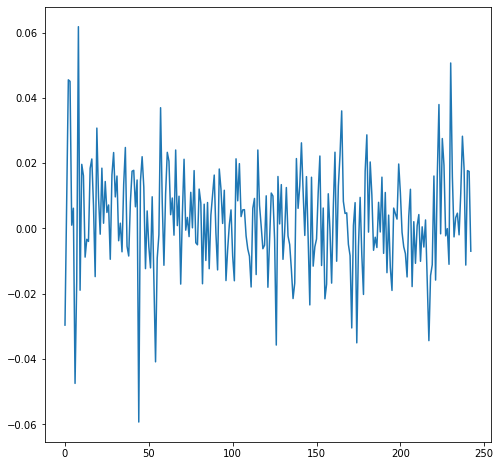

In [4]:
plt.rcParams['figure.figsize'] = (8, 8)
plt.plot(all_re)

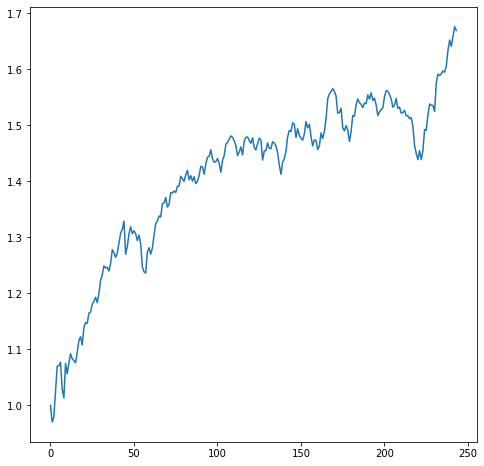

In [5]:
plt.rcParams['figure.figsize'] = (8, 8)
plt.plot(add_return(all_re))

In [6]:
df_r =  pd.DataFrame({"real_nums_return":all_nums_return,\
                      "pre_nums_return":all_nums_p_return,"rank":all_real_label,\
                      "pre_rank":all_pre})

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:2262: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


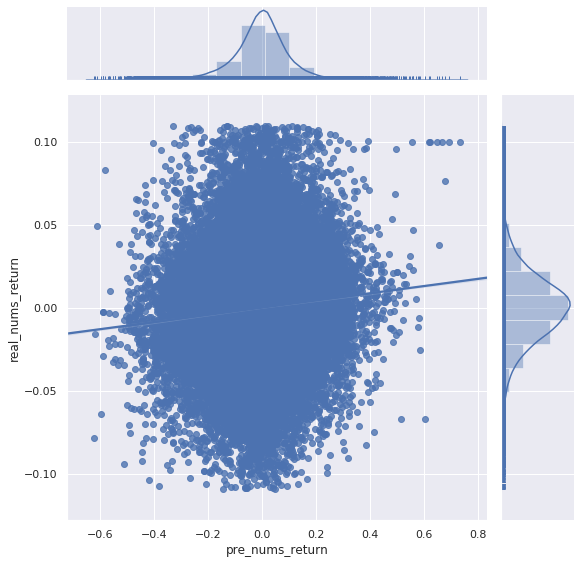

In [7]:
import seaborn as sns
sns.set(style="darkgrid")
sns.jointplot(
              x = df_r['pre_nums_return'], y = df_r['real_nums_return'],          
              data = df_r,  #设置数据                                 
              kind="reg",                                     
              size = 8, #图表大小(自动调整为正方形))             
              ratio = 5, #散点图与布局图高度比，整型             
              marginal_kws = dict(bins=15, rug =True),              
             )

In [8]:
def segment_mean(x,y,bins):
    x_range = np.linspace(min(x), max(x), bins)
    df = pd.DataFrame({"x":x, "y":y})
    df["x_cut"] = pd.cut(df["x"], x_range)
    

In [9]:
x_range = np.linspace(min(df_r["pre_nums_return"]), max(df_r["pre_nums_return"]), 10)
df_r["x_cut"] = pd.cut(df_r["pre_nums_return"], x_range, labels=list(range(9)))

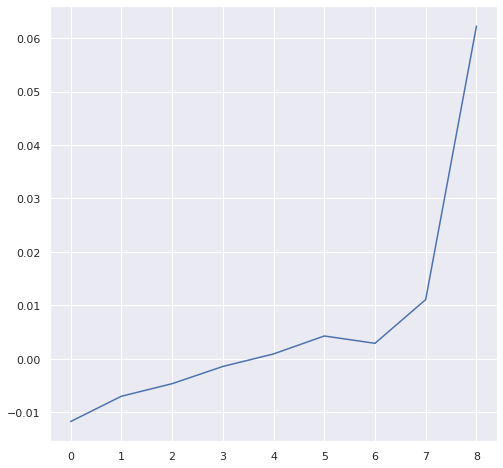

In [10]:
plt.rcParams['figure.figsize'] = (8, 8)
plt.plot(list(range(9)), list(df_r.groupby(["x_cut"])['real_nums_return'].mean()))

In [11]:
df_r["real_nums_return"].std()

0.023922426336861067

In [12]:
df_r["real_nums_return"].mean()

9.30342731118658e-06

In [13]:
df_r["real_nums_return"]

0        -0.069172
1        -0.044143
2        -0.040590
3        -0.048544
4        -0.034434
            ...   
117723   -0.018246
117724    0.024062
117725   -0.005970
117726   -0.009161
117727   -0.038565
Name: real_nums_return, Length: 117728, dtype: float64

In [14]:
for i in range(10):
    temp_df = df_r[df_r["pre_rank"] == i ]
    print(i, np.corrcoef(temp_df["real_nums_return"], temp_df["pre_nums_return"]))

0 [[1.         0.06412697]
 [0.06412697 1.        ]]
1 [[1.        0.0603175]
 [0.0603175 1.       ]]
2 [[1.         0.06487087]
 [0.06487087 1.        ]]
3 [[1.         0.08157638]
 [0.08157638 1.        ]]
4 [[1.         0.07147793]
 [0.07147793 1.        ]]
5 [[1.         0.09508695]
 [0.09508695 1.        ]]
6 [[1.         0.09058942]
 [0.09058942 1.        ]]
7 [[1.         0.08762056]
 [0.08762056 1.        ]]
8 [[1.         0.07483896]
 [0.07483896 1.        ]]
9 [[1.        0.0779218]
 [0.0779218 1.       ]]


In [15]:
np.corrcoef(df_r["rank"], df_r["pre_rank"])

array([[1.        , 0.09734399],
       [0.09734399, 1.        ]])

In [16]:
np.corrcoef(all_nums_return, all_nums_p_return)

array([[1.        , 0.09262417],
       [0.09262417, 1.        ]])

In [17]:
importance_dic

{'volume17': [0.004761904761904762],
 'low26': [0.0021164021164021165],
 'turnover13': [0.0068783068783068784],
 'close22': [0.0015873015873015873],
 'turnover22': [0.0026455026455026454],
 'open14': [0.0031746031746031746],
 'high21': [],
 'wap6': [0.009523809523809525],
 'turnover27': [0.004761904761904762],
 'open17': [0.0005291005291005291],
 'low20': [0.0031746031746031746],
 'volume11': [0.004761904761904762],
 'turnover25': [0.0031746031746031746],
 'turnover19': [0.004232804232804233],
 'volume15': [0.0031746031746031746],
 'high8': [0.0021164021164021165],
 'open20': [0.0005291005291005291],
 'volume10': [0.004232804232804233],
 'volume24': [0.00582010582010582],
 'close11': [0.0010582010582010583],
 'open11': [0.0026455026455026454],
 'low3': [0.008465608465608466],
 'close26': [0.0005291005291005291],
 'close12': [0.0010582010582010583],
 'close14': [0.0021164021164021165],
 'wap': [0.008465608465608466],
 'low11': [0.0026455026455026454],
 'high24': [0.0021164021164021165],

In [18]:
f_importance_bar(importance_dic)

['close1' 'r' 'wap2' 'wap3' 'wap1' 'amplitude' 'turnover' 'low1' 'volume'
 'open' 'high1' 'volume3' 'wap5' 'volume4' 'close' 'turnover3' 'open1'
 'volume1' 'low' 'turnover1']


utils_x.ipynb:169: RuntimeWarning: Mean of empty slice.
  "\n",
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [19]:
df_r

,real_nums_return,pre_nums_return,rank,pre_rank,x_cut
0,-0.069172,0.244254,1.0,9,5
1,-0.044143,-0.222980,3.0,0,2
2,-0.040590,0.080002,4.0,7,4
3,-0.048544,0.016985,3.0,4,4
4,-0.034434,-0.124451,5.0,0,3
...,...,...,...,...,...
117723,-0.018246,-0.037644,4.0,5,3
117724,0.024062,-0.085730,9.0,4,3
117725,-0.005970,0.022078,6.0,8,4
117726,-0.009161,-0.263151,6.0,0,2


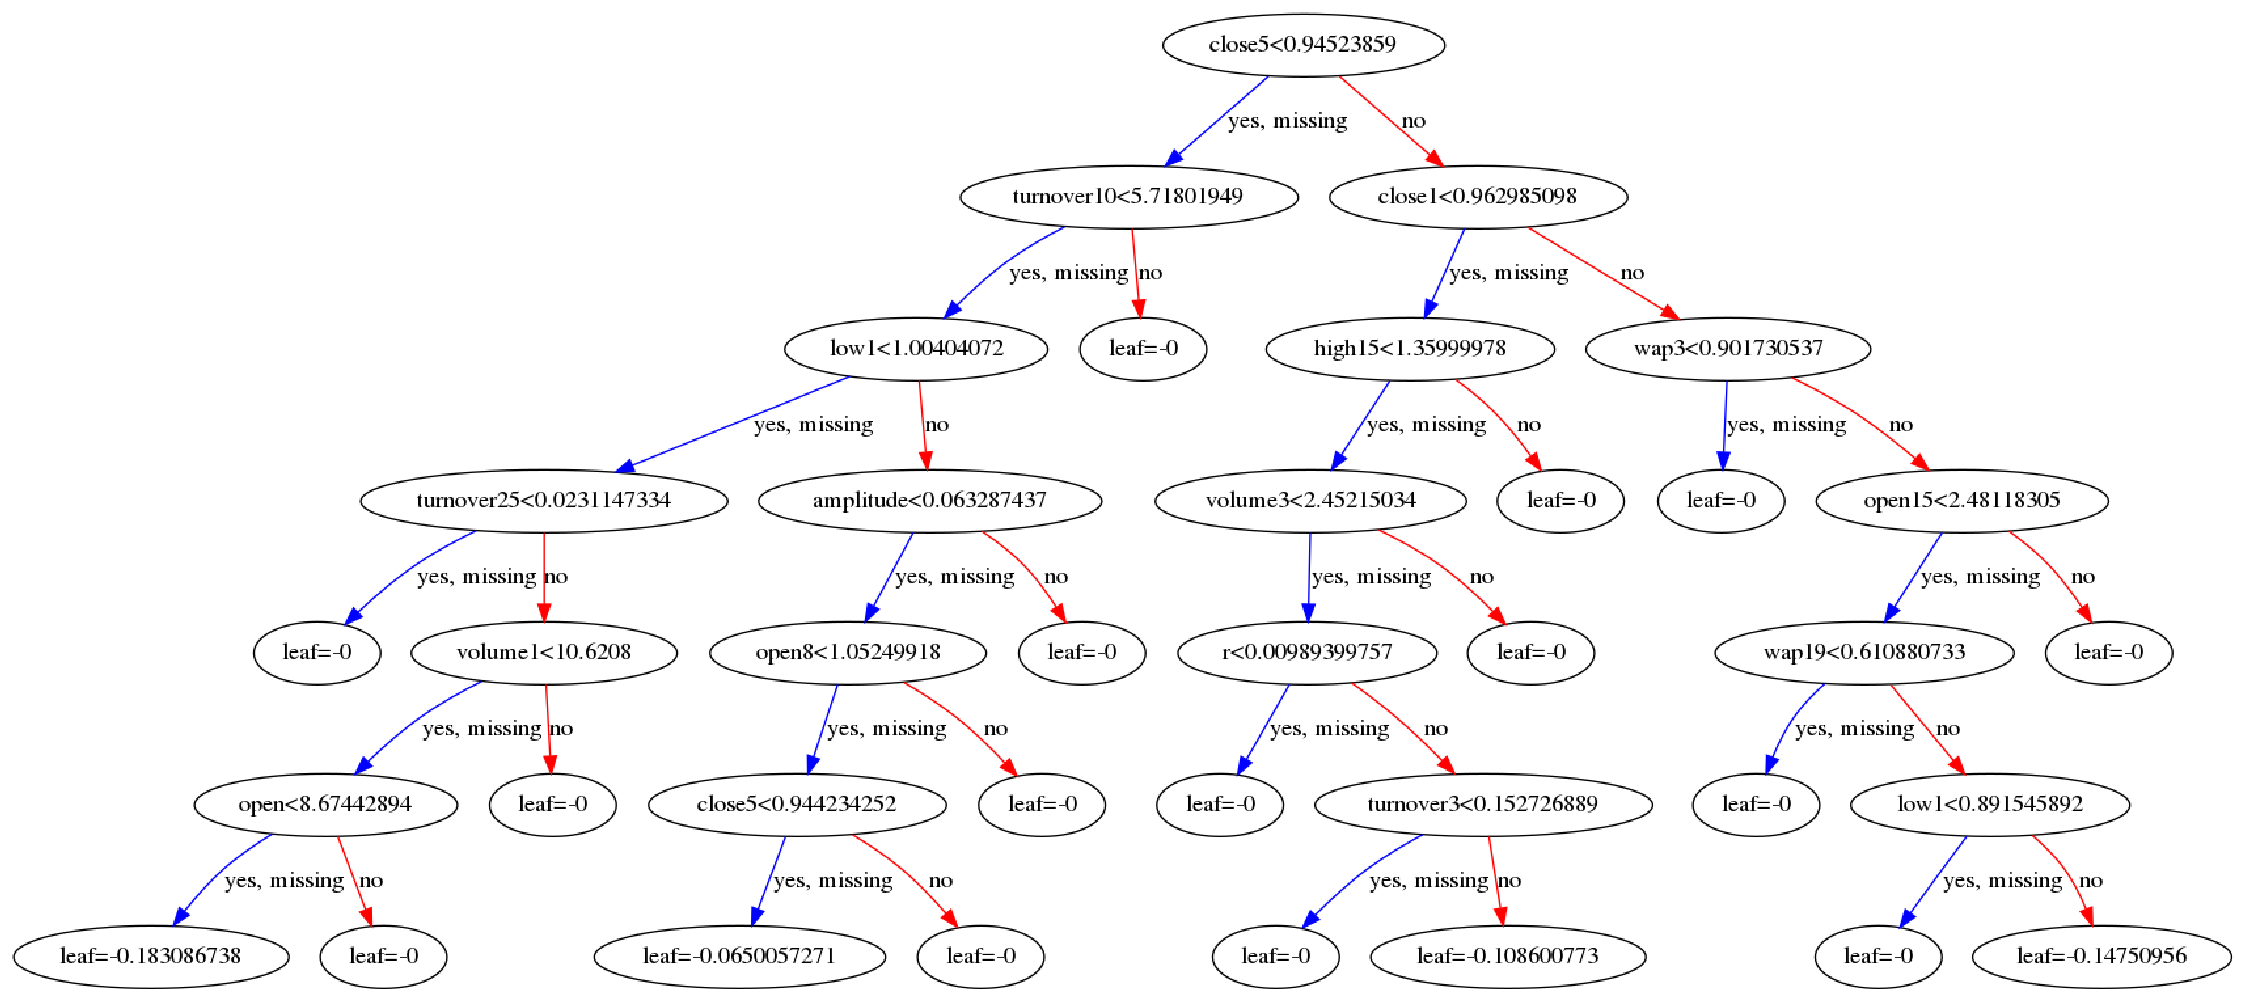

In [20]:
plt.rcParams['figure.figsize'] = (40.0, 38.0)
xgb.plot_tree(bst, num_trees=0)
plt.show()

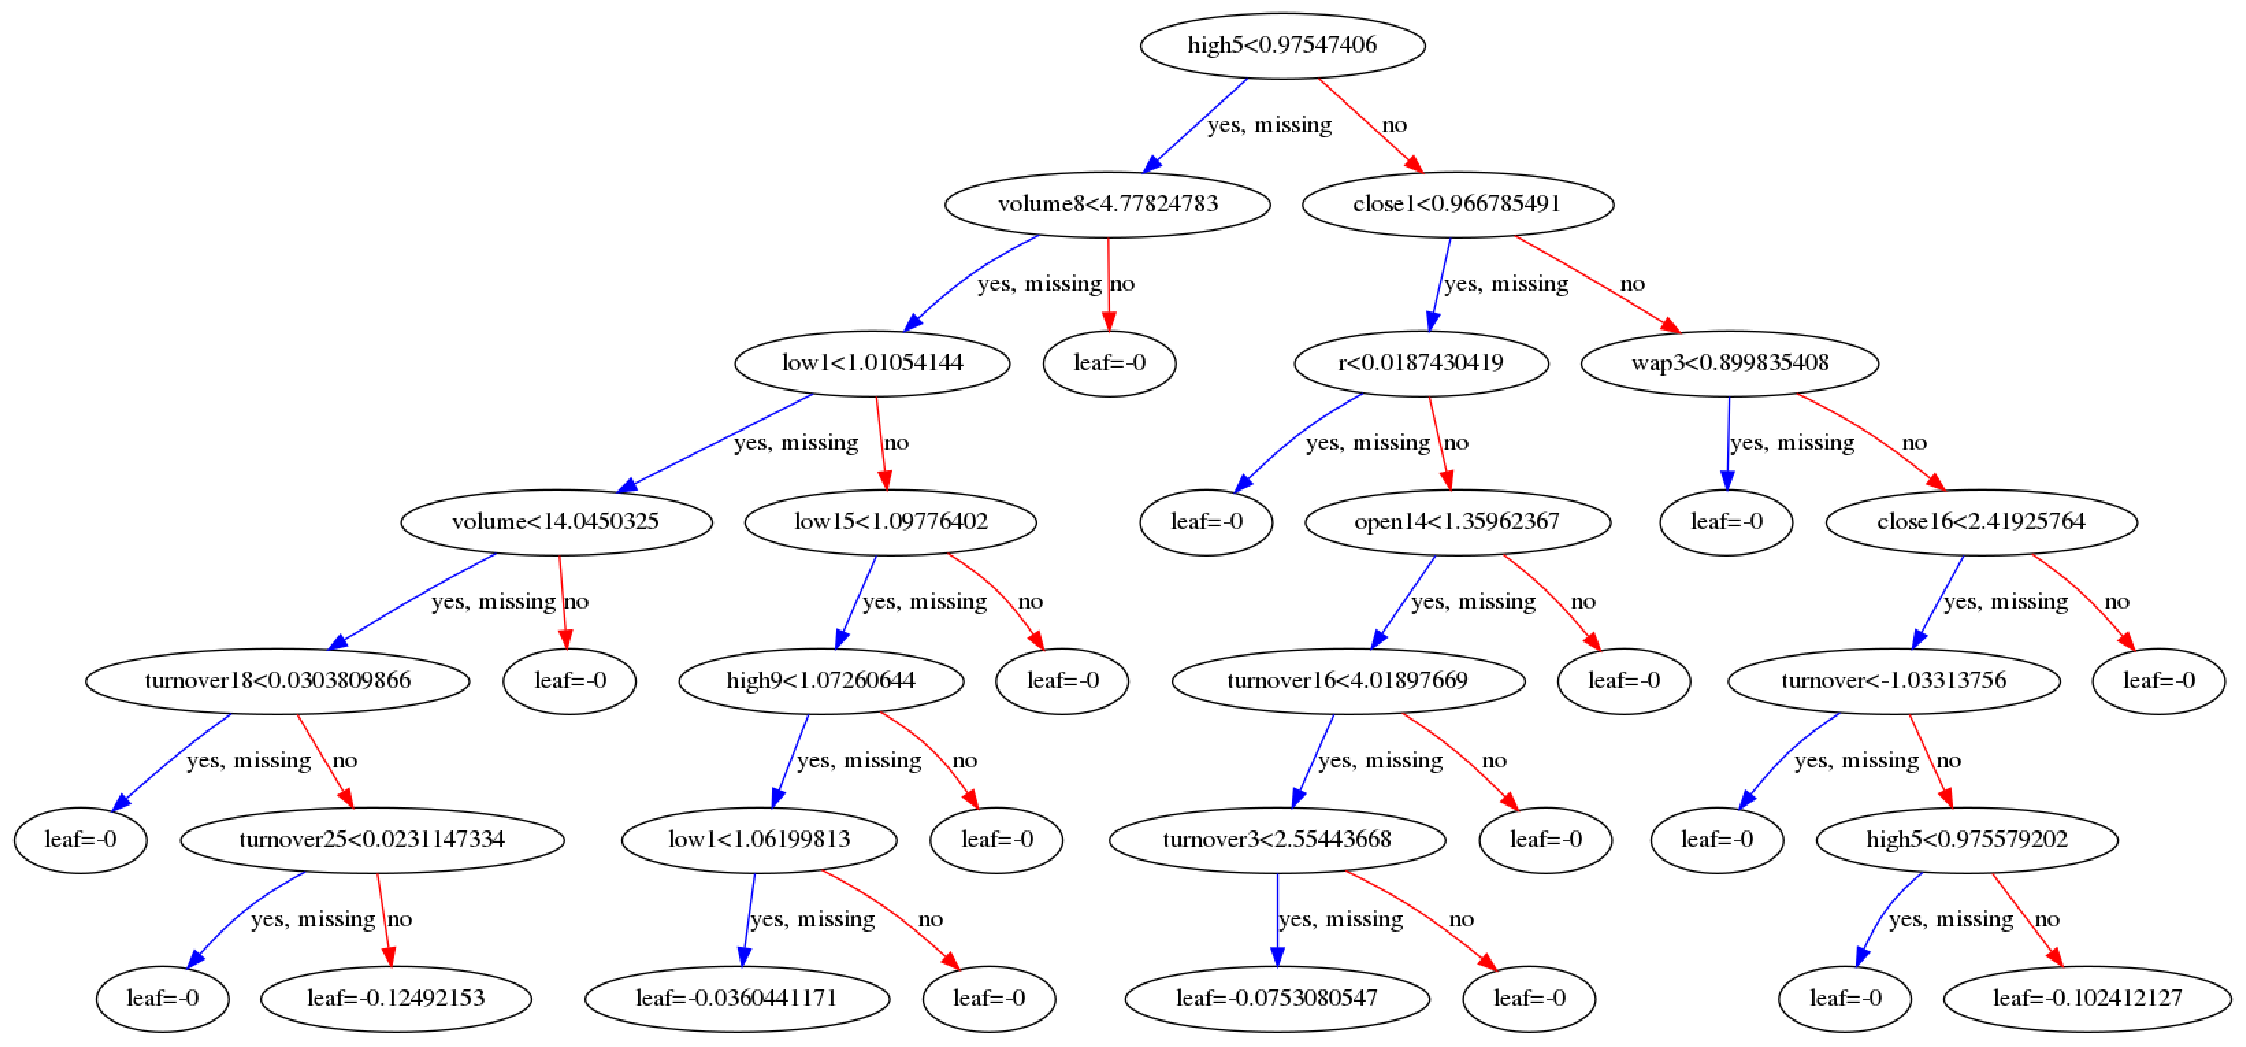

In [21]:
plt.rcParams['figure.figsize'] = (40.0, 38.0)
xgb.plot_tree(bst, num_trees=1)
plt.show()

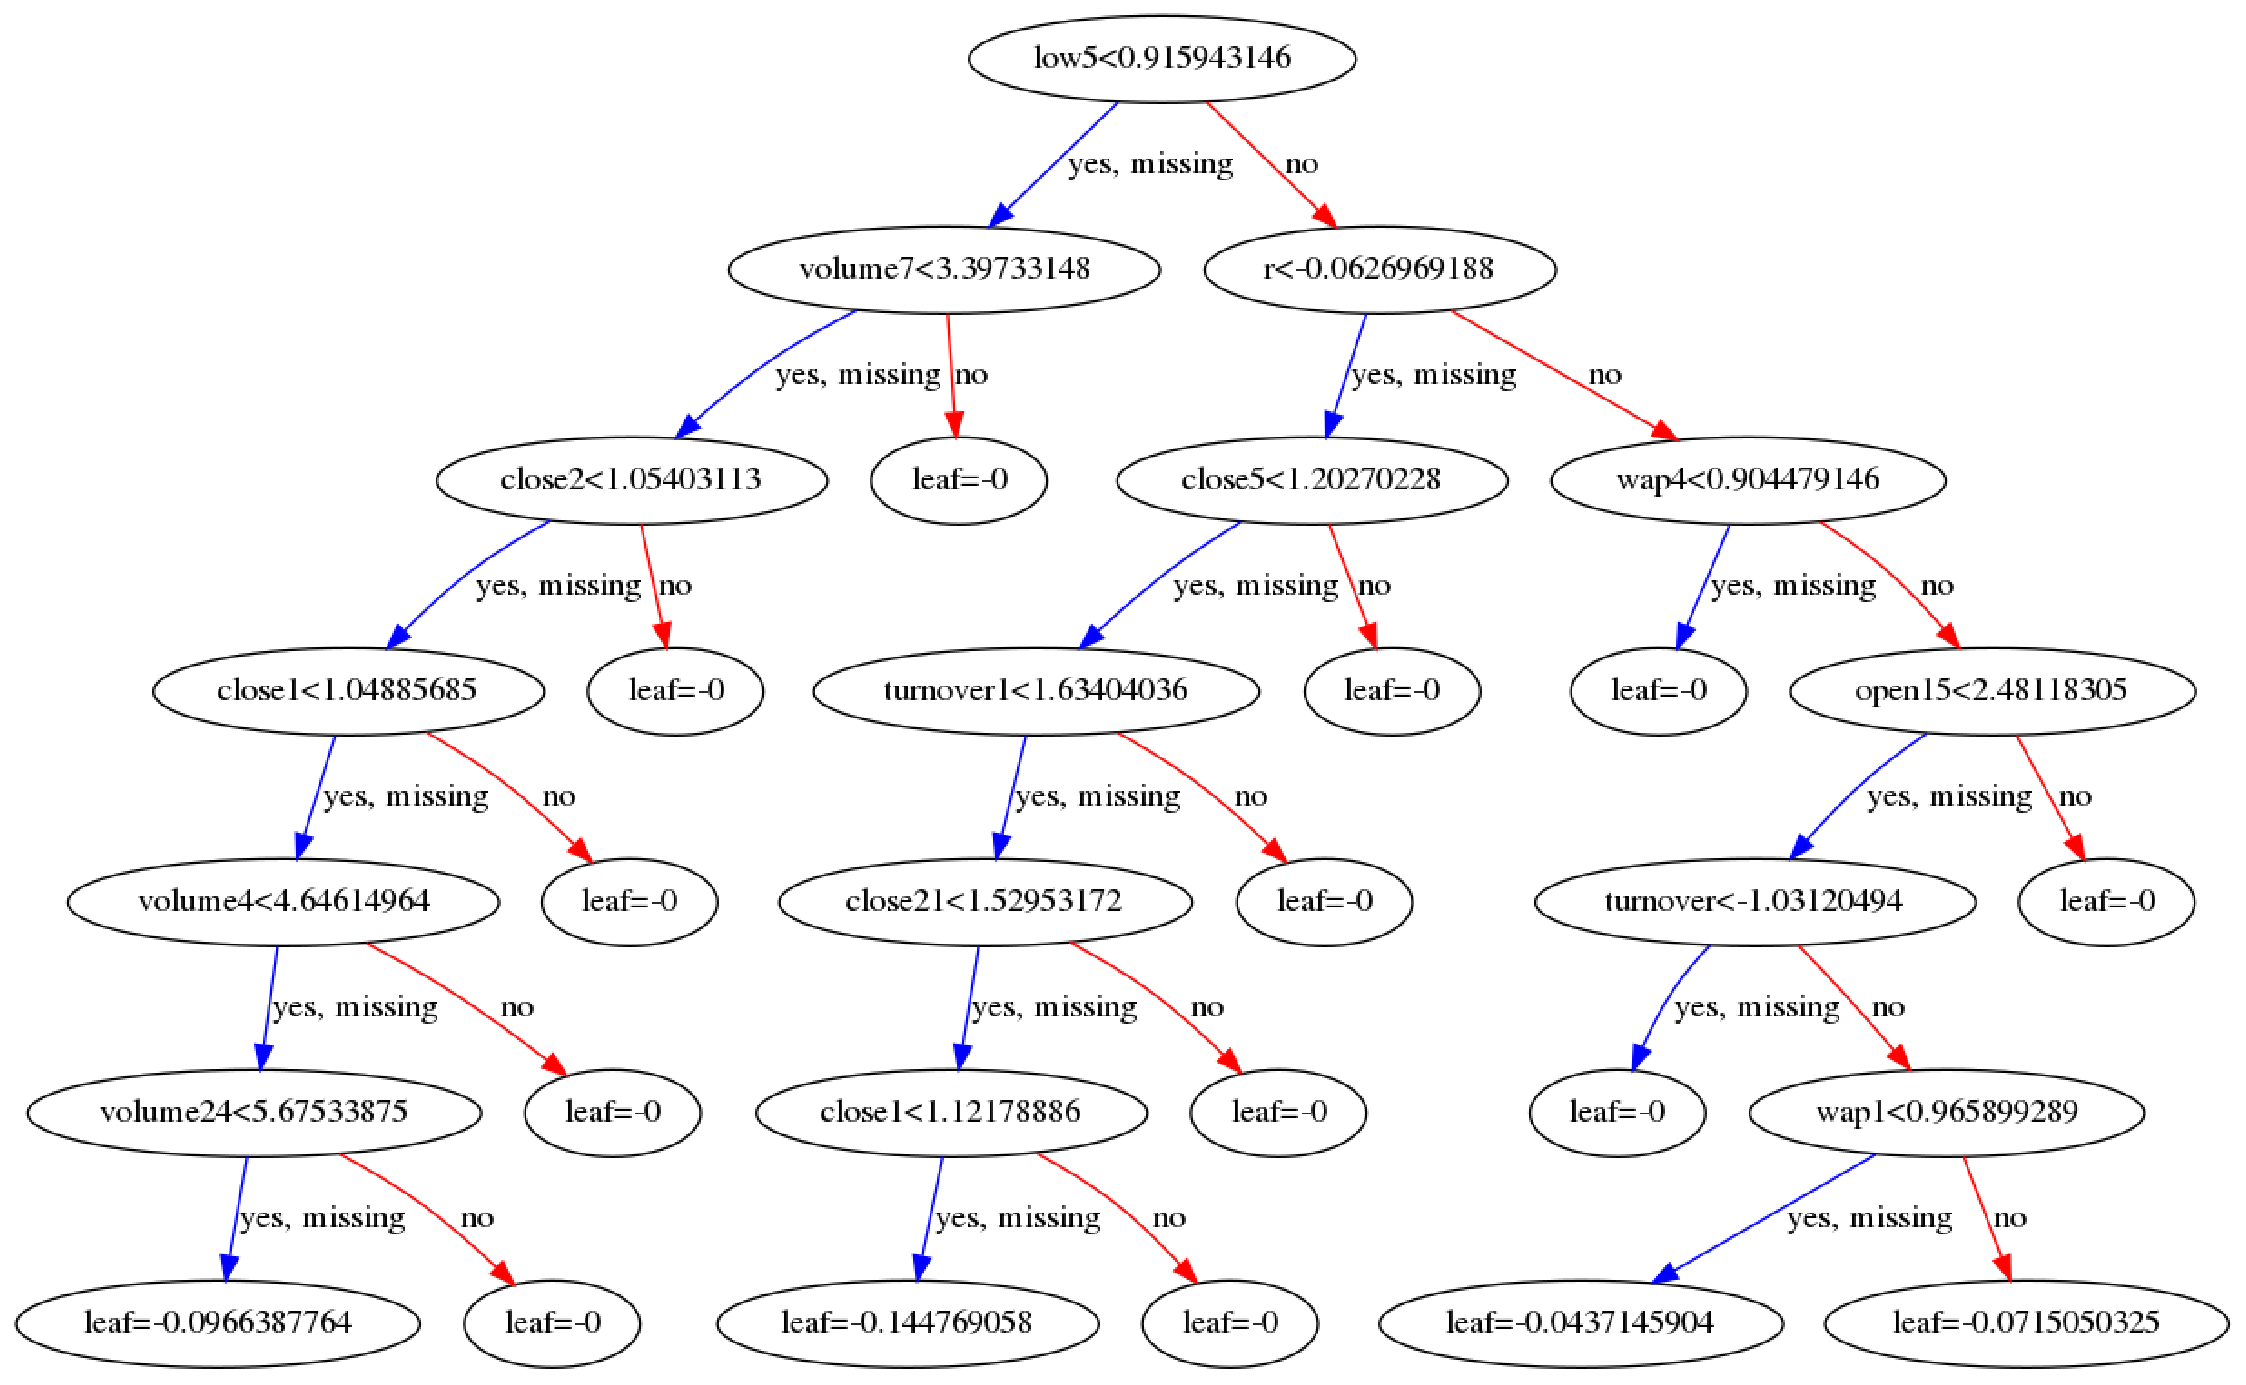

In [22]:
plt.rcParams['figure.figsize'] = (40.0, 38.0)
xgb.plot_tree(bst, num_trees=2)
plt.show()

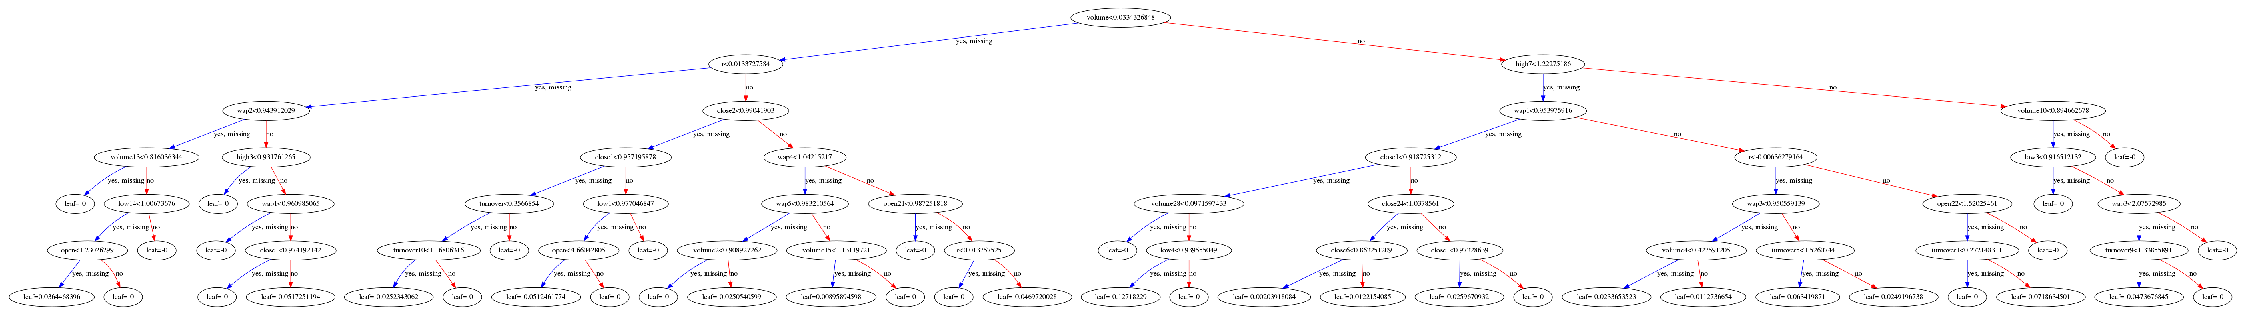

In [23]:
plt.rcParams['figure.figsize'] = (40.0, 38.0)
xgb.plot_tree(bst, num_trees=3)
plt.show()

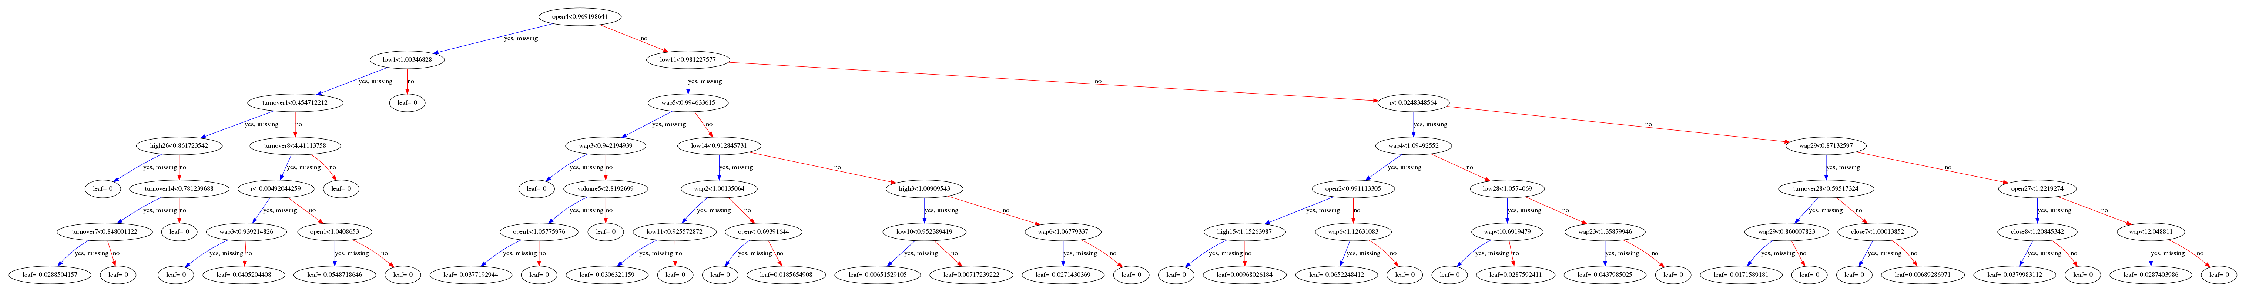

In [24]:
plt.rcParams['figure.figsize'] = (40.0, 38.0)
xgb.plot_tree(bst, num_trees=4)
plt.show()

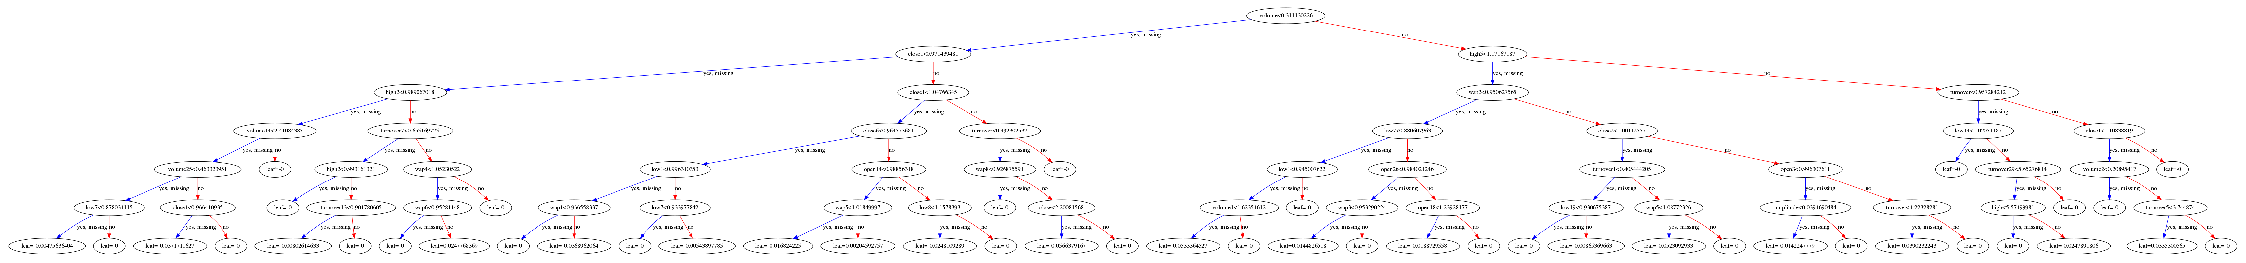

In [25]:
plt.rcParams['figure.figsize'] = (40.0, 38.0)
xgb.plot_tree(bst, num_trees=5)
plt.show()

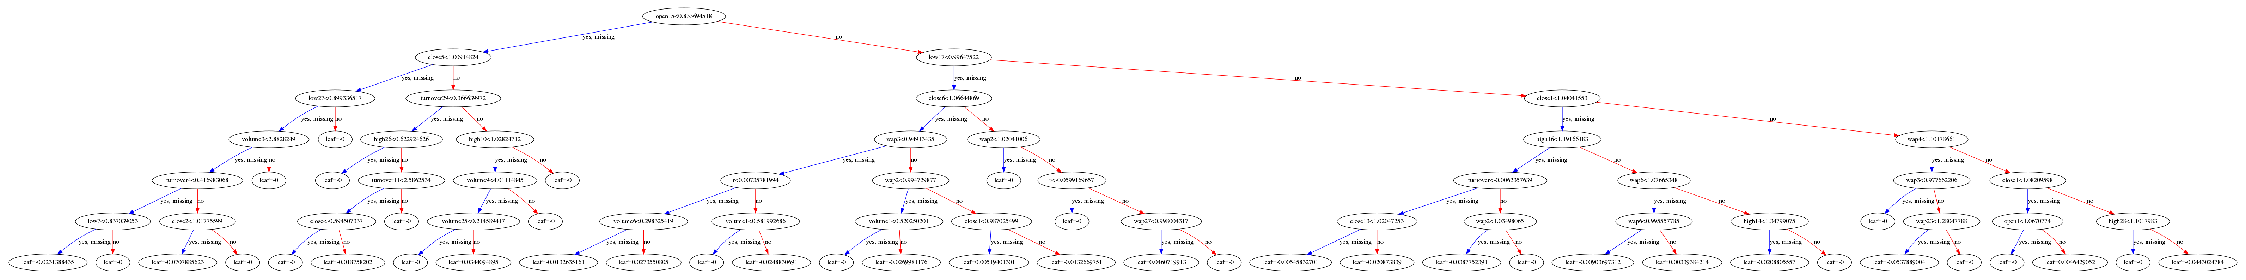

In [26]:
plt.rcParams['figure.figsize'] = (40.0, 38.0)
xgb.plot_tree(bst, num_trees=6)
plt.show()

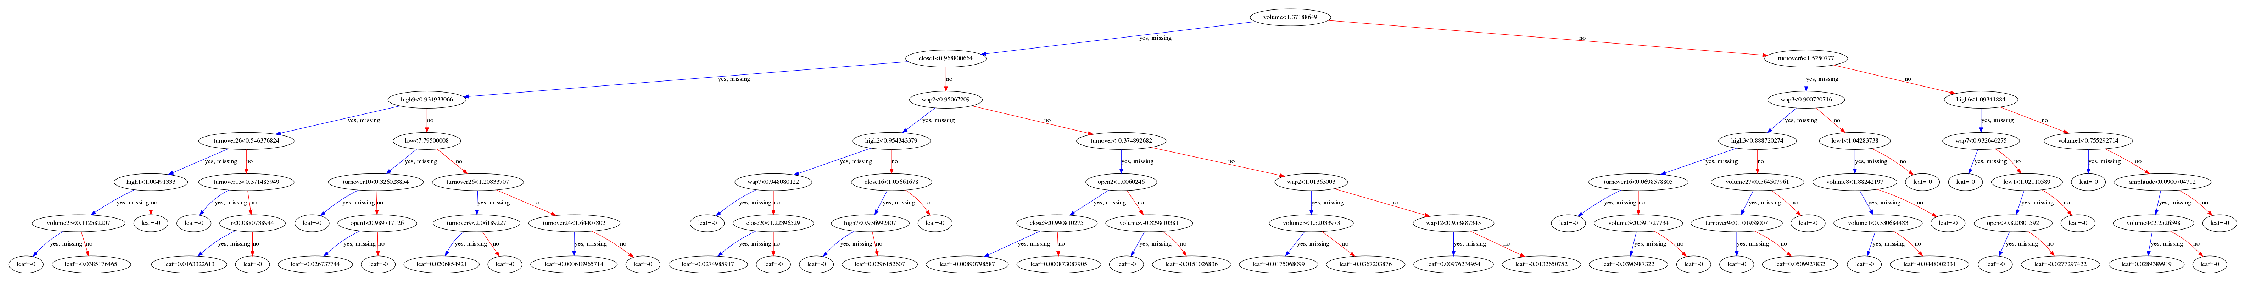

In [27]:
plt.rcParams['figure.figsize'] = (40.0, 38.0)
xgb.plot_tree(bst, num_trees=7)
plt.show()

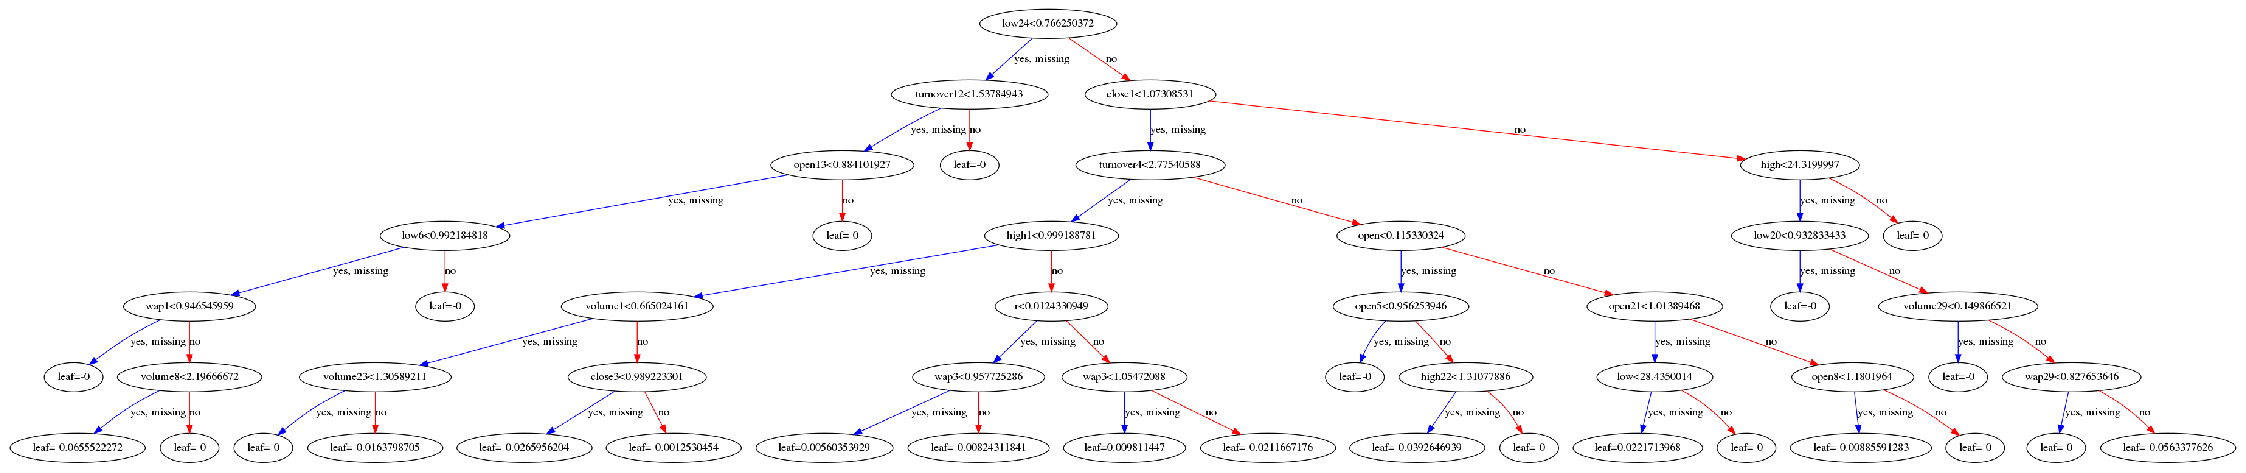

In [28]:
plt.rcParams['figure.figsize'] = (40.0, 38.0)
xgb.plot_tree(bst, num_trees=8)
plt.show()

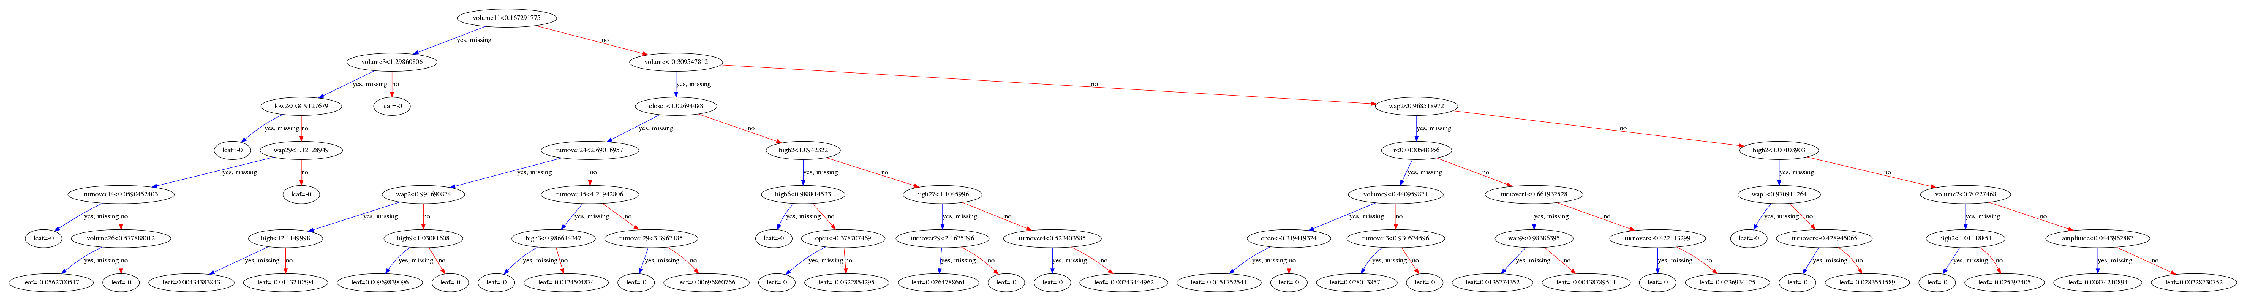

In [29]:
plt.rcParams['figure.figsize'] = (40.0, 38.0)
xgb.plot_tree(bst, num_trees=9)
plt.show()

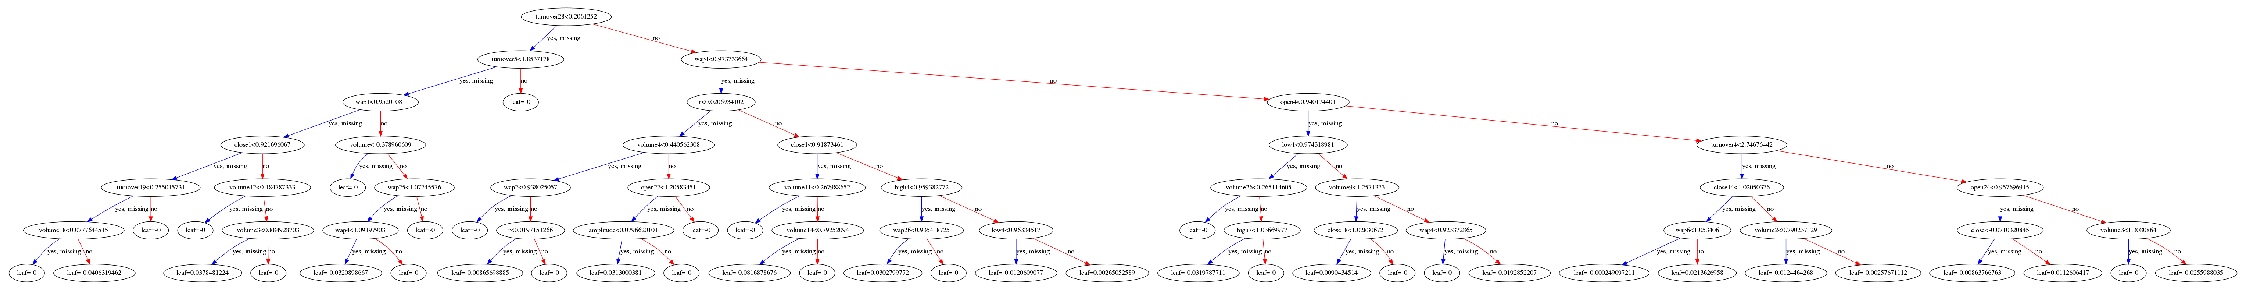

In [30]:
plt.rcParams['figure.figsize'] = (40.0, 38.0)
xgb.plot_tree(bst, num_trees=10)
plt.show()

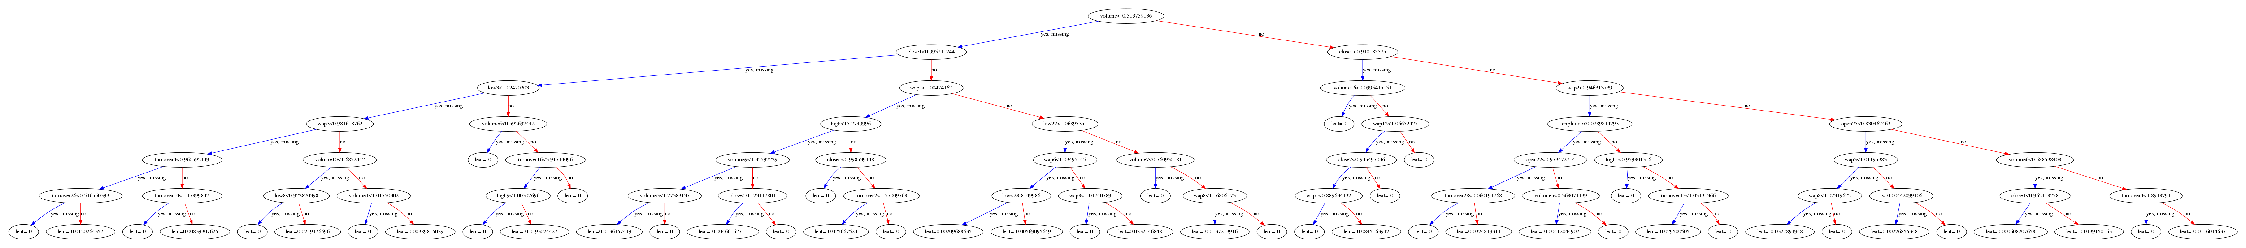

In [31]:
plt.rcParams['figure.figsize'] = (40.0, 38.0)
xgb.plot_tree(bst, num_trees=11)
plt.show()